# Librerías

In [3]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
import joblib

import a_funciones as fn

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

#Para redes
import tensorflow as tf
from keras_tuner.tuners import RandomSearch

In [4]:
# Cargar los datos escalados, la variable de respuesta y el scaler
df_historicos_scaled = joblib.load('salidas/df_historicos_transf.pkl')
y = joblib.load('salidas/v.respuesta.pkl')
sc = joblib.load('salidas/scaler.pkl')

In [5]:
df_historicos_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   CreditScore                      10000 non-null  float64
 1   DebtRatio                        10000 non-null  float64
 2   Assets                           10000 non-null  float64
 3   Age                              10000 non-null  float64
 4   NumberOfDependents               10000 non-null  float64
 5   NumberOfOpenCreditLinesAndLoans  10000 non-null  float64
 6   MonthlyIncome                    10000 non-null  float64
 7   NumberOfTimesPastDue             10000 non-null  float64
 8   EmploymentLength                 10000 non-null  float64
 9   YearsAtCurrentAddress            10000 non-null  float64
 10  HomeOwnership_Mortgage           10000 non-null  float64
 11  HomeOwnership_Own                10000 non-null  float64
 12  HomeOwnership_Rent 

In [6]:
df_new_credit = pd.read_csv('data/datos_nuevos_creditos.csv')
df_new_credit.head()

,ID,CreditScore,DebtRatio,Assets,Age,NumberOfDependents,NumberOfOpenCreditLinesAndLoans,MonthlyIncome,NumberOfTimesPastDue,EmploymentLength,HomeOwnership,Education,MaritalStatus,YearsAtCurrentAddress,NewLoanApplication
0,10001,737,0.479047,34979,63,6,12,2904,8,15,Mortgage,High School,Widowed,20,37752.0
1,10002,411,0.442930,56459,28,7,4,17639,11,4,Rent,High School,Widowed,21,52917.0
2,10003,732,0.532314,76570,26,5,8,17730,7,10,Rent,High School,Widowed,10,106380.0
3,10004,710,0.295541,86752,51,8,16,7166,16,18,Mortgage,Masters,Widowed,17,35830.0
4,10005,848,0.248378,102286,29,4,8,4688,16,1,Own,High School,Widowed,26,32816.0


In [7]:
df_new_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1058 entries, 0 to 1057
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               1058 non-null   int64  
 1   CreditScore                      1058 non-null   int64  
 2   DebtRatio                        1058 non-null   float64
 3   Assets                           1058 non-null   int64  
 4   Age                              1058 non-null   int64  
 5   NumberOfDependents               1058 non-null   int64  
 6   NumberOfOpenCreditLinesAndLoans  1058 non-null   int64  
 7   MonthlyIncome                    1058 non-null   int64  
 8   NumberOfTimesPastDue             1058 non-null   int64  
 9   EmploymentLength                 1058 non-null   int64  
 10  HomeOwnership                    1058 non-null   object 
 11  Education                        1058 non-null   object 
 12  MaritalStatus       

In [8]:
monto_credito = df_new_credit['NewLoanApplication']

In [9]:
del df_new_credit['NewLoanApplication']
del df_new_credit['ID']

In [10]:
df_new_credit.head()

,CreditScore,DebtRatio,Assets,Age,NumberOfDependents,NumberOfOpenCreditLinesAndLoans,MonthlyIncome,NumberOfTimesPastDue,EmploymentLength,HomeOwnership,Education,MaritalStatus,YearsAtCurrentAddress
0,737,0.479047,34979,63,6,12,2904,8,15,Mortgage,High School,Widowed,20
1,411,0.442930,56459,28,7,4,17639,11,4,Rent,High School,Widowed,21
2,732,0.532314,76570,26,5,8,17730,7,10,Rent,High School,Widowed,10
3,710,0.295541,86752,51,8,16,7166,16,18,Mortgage,Masters,Widowed,17
4,848,0.248378,102286,29,4,8,4688,16,1,Own,High School,Widowed,26


In [11]:
df_newcredit_sc, _ = fn.procesar_datos(df_new_credit, scaler=sc)
df_newcredit_sc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1058 entries, 0 to 1057
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   CreditScore                      1058 non-null   float64
 1   DebtRatio                        1058 non-null   float64
 2   Assets                           1058 non-null   float64
 3   Age                              1058 non-null   float64
 4   NumberOfDependents               1058 non-null   float64
 5   NumberOfOpenCreditLinesAndLoans  1058 non-null   float64
 6   MonthlyIncome                    1058 non-null   float64
 7   NumberOfTimesPastDue             1058 non-null   float64
 8   EmploymentLength                 1058 non-null   float64
 9   YearsAtCurrentAddress            1058 non-null   float64
 10  HomeOwnership_Mortgage           1058 non-null   float64
 11  HomeOwnership_Own                1058 non-null   float64
 12  HomeOwnership_Rent  

# Segmentación

Realizar selección de variables con PCA

In [12]:
#variables con respecto a las variables y componentes

kmeans = KMeans(n_clusters=3, random_state=42)
df_historicos_scaled['Segmento'] = kmeans.fit_predict(df_historicos_scaled)

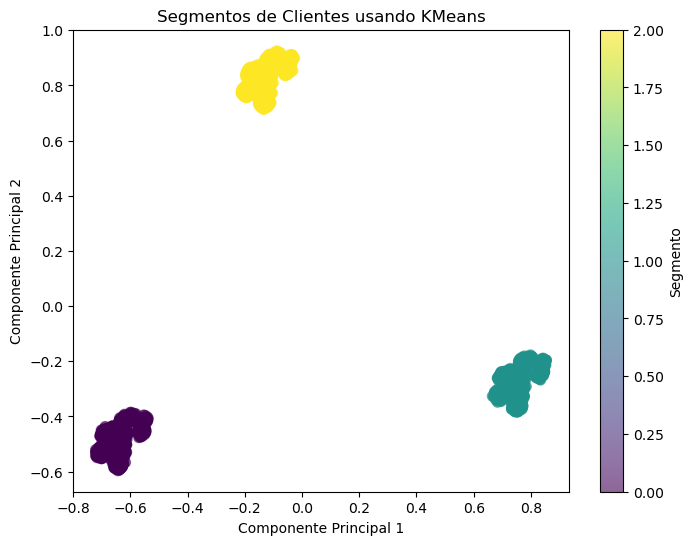

In [13]:
# Aplicar PCA para reducir las dimensiones a 2
pca = PCA(n_components=2)
df_historicos_scaled_pca = pca.fit_transform(df_historicos_scaled.drop(columns=['Segmento']))

plt.figure(figsize=(8, 6))
plt.scatter(df_historicos_scaled_pca[:, 0], df_historicos_scaled_pca[:, 1], c=df_historicos_scaled['Segmento'], cmap='viridis', s=50, alpha=0.6)

plt.title('Segmentos de Clientes usando KMeans')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

plt.colorbar(label='Segmento')
plt.show()

# Train / Test

In [14]:
from sklearn.model_selection import train_test_split
x = df_historicos_scaled 

In [15]:
# Separar datos
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

#Imprimir Tamaño de dataset, corresponden al 80,20
print("Tamaño del conjunto de entrenamiento. X: ", X_train.shape," Y: ", y_train.shape)
print("Tamaño del conjunto de validación. X: ", X_test.shape," Y: ", y_test.shape )


Tamaño del conjunto de entrenamiento. X:  (7000, 22)  Y:  (7000,)
Tamaño del conjunto de validación. X:  (3000, 22)  Y:  (3000,)


# Modelos

## Redes neuronales

In [ ]:
regression_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])

In [ ]:
# Configurar el optimizador y la función de pérdida para un problema de regresión
regression_model.compile(optimizer='adam', loss='mse', metrics=[MeanSquaredError(), RootMeanSquaredError()])

# Entrenar el modelo usando el optimizador y la arquitectura definidas
regression_model.fit(X_train, y_train, batch_size=100, epochs=10, validation_data=(X_test, y_test))

# Evaluar el modelo
test_loss, test_mse, test_rmse = regression_model.evaluate(X_test, y_test, verbose=2)

print("Test Mean Squared Error:", test_mse)
print("Test Root Mean Squared Error:", test_rmse)

In [ ]:
# Definir la función de creación del modelo
def build_model(hp):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=X_train.shape[1:]))

    # Añadir capas ocultas con hiperparámetros para el número de unidades y la activación
    for i in range(hp.Int('num_layers', 1, 6)):
        model.add(tf.keras.layers.Dense(
            units=64,  # Número fijo de unidades en cada capa
            activation=hp.Choice('activation', ['relu', 'tanh']),
            kernel_initializer=hp.Choice('init_mode', ['uniform', 'he_normal'])
        ))

    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # Compilar el modelo con hiperparámetros para el optimizador
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=[tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.RootMeanSquaredError()]
    )

    return model

In [ ]:
# Crear el tuner
tuner = RandomSearch(
    build_model,
    objective='val_mean_squared_error',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='helloworld'
)

# Realizar la búsqueda de hiperparámetros
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=100)

# Obtener los mejores hiperparámetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


# Mostrar los mejores hiperparámetros
print("Best Hyperparameters:")
print(f"- Number of layers: {best_hps.get('num_layers')}")


In [ ]:
# Hacer predicciones con el modelo entrenado
y_pred_nuevos = regression_model.predict(df_newcredit_sc)

In [ ]:
## Residuales

# Obtener las predicciones del modelo en los datos de prueba
y_pred = regression_model.predict(X_test).flatten()

# Calcular los residuales
residuales = y_test - y_pred

# Histograma de los residuales
plt.figure(figsize=(8, 6))
plt.hist(residuales, bins=20, edgecolor='k')
plt.title('Histograma de Residuales')
plt.xlabel('Residual')
plt.ylabel('Frecuencia')
plt.show()

# Gráfico de dispersión de los residuales vs. predicciones
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuales, alpha=0.5)
plt.title('Residuales vs. Predicciones')
plt.xlabel('Predicciones')
plt.ylabel('Residuales')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# Gráfico de dispersión de los residuales vs. el valor verdadero
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuales, alpha=0.5)
plt.title('Residuales vs. Valor Verdadero')
plt.xlabel('Valor Verdadero')
plt.ylabel('Residuales')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [ ]:
# Crear el histograma de las predicciones
plt.figure(figsize=(8, 4))
plt.hist(y_pred_nuevos, bins=20, color='skyblue', edgecolor='black')
plt.title('Histograma de Predicciones')
plt.xlabel('Valor Predicho')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

In [ ]:
df_predic = df_new_credit.copy()
df_predic['NoPaidPer'] = y_pred_nuevos
df_predic

In [ ]:
# Filtrar las predicciones que están entre 0 y 0.1
tasa1 = df_predic.loc[(df4['predicciones'] >= 0) & (df_predic['predicciones'] < 0.15)]
# Filtrar las predicciones que están entre 0 y 0.1
tasa2 = df_predic.loc[(df_predic['predicciones'] >= 0.15)]

print(tasa1.shape)
print(tasa2.shape)

## XGBoost

In [ ]:
#pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB 163.8 kB/s eta 0:12:43
   ---------------------------------------- 0.1/124.9 MB 504.4 kB/s eta 0:04:08
   ---------------------------------------- 0.7/124.9 MB 2.7 MB/s eta 0:00:46
   ---------------------------------------- 1.1/124.9 MB 3.9 MB/s eta 0:00:32
    --------------------------------------- 1.6/124.9 MB 4.6 MB/s eta 0:00:27
    --------------------------------------- 2.5/124.9 MB 6.2 MB/s eta 0:00:20
   - -------------------------------------- 3.5/124.9 MB 7.7 MB/s eta 0:00:16
   - -------------------------------------- 4.7/124.9 MB 9.3 MB/s eta 0:00:13
   - -------------------------------------- 5.6/124.9 MB 9.7 MB/s eta 0:00:13
   - -----

In [20]:
# Librerias necesarias
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from sklearn.datasets import load_iris
import xgboost as xgb
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [22]:
# create model instance
bst = XGBRegressor(n_estimators=2, max_depth=2, learning_rate=1, objective='reg:squarederror')

# fit model
bst.fit(X_train, y_train)

# make predictions
preds = bst.predict(X_test)

msewr = MSE(y_test, preds)
rmsewr = np.sqrt(msewr)

print("MSE : % f" %(msewr))
print("RMSE: % f" % rmsewr)

MSE :  0.002638
RMSE:  0.051363


In [23]:
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
)

param_grid = {
    'n_estimators': [10, 50, 100, 500, 1000, 5000],
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_n_estimators = grid_search.best_params_['n_estimators']
best_model = grid_search.best_estimator_

best_n_estimators

#Entrenamos el modelo luego de la optimizacion de hiperparametros

best_model.fit(X_train, y_train)

# make predictions
preds = best_model.predict(X_test)

msewr = MSE(y_test, preds)
rmsewr = np.sqrt(msewr)

print("MSE : % f" %(msewr))
print("RMSE: % f" % rmsewr)

MSE :  0.000698
RMSE:  0.026422
